In [28]:
!pip install scanpy anndata umap-learn keras-tuner tensorflow scikit-learn matplotlib seaborn pandas

PCA_all = False
PCA_healthy = True
HVG_all = False
HVG_healthy = False
classification = False

dimensions = 80


import scanpy as sc
import anndata
from anndata import read_h5ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [29]:
# load and normalize the data
train_data = anndata.read_h5ad("all_data_10percent.h5ad")
sc.pp.normalize_total(train_data, target_sum=1e4)
sc.pp.log1p(train_data)

In [30]:
### --- PCA all --- ###

if PCA_all:
  PCA_components = dimensions
  pca = PCA(n_components=PCA_components)

  # PCA defined by all cells
  train_data.obsm["X_pca"] = pca.fit_transform(train_data.X)
  all_data_normalized = train_data.obsm["X_pca"]

  # Sort out healthy cells for training
  healthy_cells = all_data_normalized[train_data.obs["disease"] == "normal"]
  X_train = healthy = healthy_cells.copy()


In [31]:
### --- PCA healthy --- ###

if PCA_healthy:
  PCA_components = dimensions

  # Identify healthy cells
  healthy_mask = train_data.obs["disease"] == "normal"
  healthy_data = train_data[healthy_mask]

  # Fit PCA only on healthy cells
  pca = PCA(n_components=PCA_components)
  healthy_pca = pca.fit_transform(healthy_data.X)

  # Apply the PCA transformation to **all** cells
  train_data.obsm["X_pca"] = pca.transform(train_data.X)

  # Save for modeling
  all_data_normalized = train_data.obsm["X_pca"]

  # Split only healthy cells for training
  X_train = healthy_cells = all_data_normalized[healthy_mask]


In [32]:
### --- Highly variable genes all --- ###

if HVG_all:
  num_genes = dimensions

  # Find top 80 highly variable genes from all data
  sc.pp.highly_variable_genes(train_data, n_top_genes=num_genes, flavor="seurat")

  # Save gene mask
  hvg_mask = train_data.var["highly_variable"]
  selected_genes = train_data.var_names[hvg_mask].to_list()

  # Filter full dataset by HVGs
  train_data_reduced = train_data[:, hvg_mask].copy()

  # Extract healthy cell mask
  healthy_mask = train_data.obs["disease"] == "normal"

  # Extract healthy training matrix using selected HVGs
  X_train_ = train_data_reduced.X[healthy_mask.values]
  X_train = X_train_.toarray().astype("float32")


In [33]:
### --- Highly variable genes healthy only --- ###

if HVG_healthy:
  num_genes = dimensions

  # Identify highly variable genes based only on healthy cells
  healthy_mask = train_data.obs["disease"] == "normal"
  healthy_data = train_data[healthy_mask].copy()

  # Find top 80 highly variable genes in healthy cells
  sc.pp.highly_variable_genes(healthy_data, n_top_genes=num_genes, flavor="seurat")

  # Save gene mask
  hvg_mask = healthy_data.var["highly_variable"]
  selected_genes = healthy_data.var_names[hvg_mask].to_list()

  # Filter the full dataset (not just healthy) to those top 80 genes
  train_data_reduced = train_data[:, hvg_mask].copy()

  # Get expression matrix
  all_data_normalized = train_data_reduced.X

  # Split only healthy cells for training
  X_train_ = all_data_normalized[healthy_mask.values]
  X_train = X_train_.toarray().astype("float32")


In [34]:
#if classification:
if classification:
  num_genes = dimensions

  # Import most important genes list
  with open("top_1000_genes.txt", "r") as f:
    full_gene_list = [line.strip() for line in f]

  selected_genes = full_gene_list[:num_genes]
  train_data_reduced = train_data[:, selected_genes].copy()

  # Extract healthy cell mask
  healthy_mask = train_data.obs["disease"] == "normal"

  # Extract healthy training matrix using selected HVGs
  X_train_ = train_data_reduced.X[healthy_mask.values]
  X_train = X_train_.toarray().astype("float32")


In [35]:
# import new data and normalize
test_data = anndata.read_h5ad("all_data_10percent_test.h5ad")
sc.pp.normalize_total(test_data, target_sum=1e4)
sc.pp.log1p(test_data)


In [36]:
### --- PCA all --- ###
if PCA_all:
  loaded_model = keras.models.load_model("best_autoencoder_model.keras")
  loaded_model.summary()

  test_data.obsm["X_pca"] = pca.transform(test_data.X)
  test_data_normalized = test_data.obsm["X_pca"]
  X_test = test_data_normalized

### --- PCA healthy --- ###
if PCA_healthy:
  loaded_model = keras.models.load_model("best_autoencoder_PCA_only_healthy.keras")
  loaded_model.summary()

  test_data.obsm["X_pca"] = pca.transform(test_data.X)
  test_data_normalized = test_data.obsm["X_pca"]
  X_test = test_data_normalized

  ### --- Highly variable genes all --- ###
if HVG_all:
  loaded_model = keras.models.load_model("best_autoencoder_HighV_all.keras")
  loaded_model.summary()

  test_data_reduced = test_data[:, selected_genes].copy()
  X_test = test_data_reduced.X

  ### --- Highly variable genes healthy --- ###
if HVG_healthy:
  loaded_model = keras.models.load_model("best_autoencoder_HighV_only_healthy.keras")
  loaded_model.summary()

  test_data_reduced = test_data[:, selected_genes].copy()
  X_test = test_data_reduced.X

  ### --- classification variables --- ###
  if classification:
    loaded_model = keras.models.load_model("best_autoencoder_class.keras")
    loaded_model.summary()

    test_data_reduced = test_data[:, selected_genes].copy()
    X_test = test_data_reduced.X

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │        40,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 290)            │        58,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │        23,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,812 (2.54 MB)

 Trainable params: 222,270 (868.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 444,542 (1.70 MB)

In [37]:
### --- Reconstruction error --- ###
#X_test = X_test.toarray().astype("float32")
#X_test = X_test.toarray().astype("float32")
X_pred = loaded_model.predict(X_test)

errors = np.mean((X_test - X_pred) ** 2, axis=1)
print(X_test.shape, X_pred.shape, errors.shape)

# Add to AnnData for plotting
test_data.obs["reconstruction_error"] = errors

944/944 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
(30180, 80) (30180, 80) (30180,)


In [43]:
from sklearn.metrics import roc_curve, auc as sklearn_auc

# Prepare data
scores = test_data.obs["reconstruction_error"]
labels = test_data.obs["disease"]
unique_diseases = sorted(labels.unique())  # sorted ensures consistent order
palette = sns.color_palette("tab10", len(unique_diseases))
color_map = dict(zip(unique_diseases, palette))  # disease → color

# Define diseases to compare against normal
disease_classes = [d for d in unique_diseases if d != "normal"][:4]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Histogram with consistent colors ---
sns.histplot(data=test_data.obs, x="reconstruction_error", hue="disease",
             palette=color_map, bins=200, element="step", stat="density", common_norm=False, ax=axes[0], alpha=0.2)
axes[0].set_title("Reconstruction Error Histogram")
axes[0].set_xlabel("Reconstruction Error")
axes[0].set_xlim(0, 0.2)
axes[0].set_ylim(0, 40)
axes[0].axvline(x=0.019, color='green', linestyle='--', linewidth=1)
axes[0].axvline(x=0.015, color='red', linestyle='--', linewidth=1)
axes[0].axvline(x=0.017, color='blue', linestyle='--', linewidth=1)
axes[0].set_ylabel("Density")

# --- ROC curves: each disease vs normal, using matching colors ---
for disease in disease_classes:
    mask = (labels == "normal") | (labels == disease)
    binary_labels = (labels[mask] == disease).astype(int)
    binary_scores = scores[mask]

    fpr, tpr, thresholds = roc_curve(binary_labels, binary_scores)
    roc_auc = sklearn_auc(fpr, tpr)

    # Optimal threshold (Youden’s J)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]

    # Plot ROC
    color = color_map[disease]
    axes[1].plot(fpr, tpr, label=f"{disease} (AUC = {roc_auc:.2f})", color=color)
    axes[1].plot(fpr[best_idx], tpr[best_idx], 'o', color=color, markersize=6)
    axes[1].annotate(f"{best_threshold:.3f}", (fpr[best_idx], tpr[best_idx]),
                     textcoords="offset points", xytext=(5, -10), ha='left', fontsize=8)

# Random classifier line
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.6)

axes[1].set_title("ROC Curves: Each Disease vs Normal")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


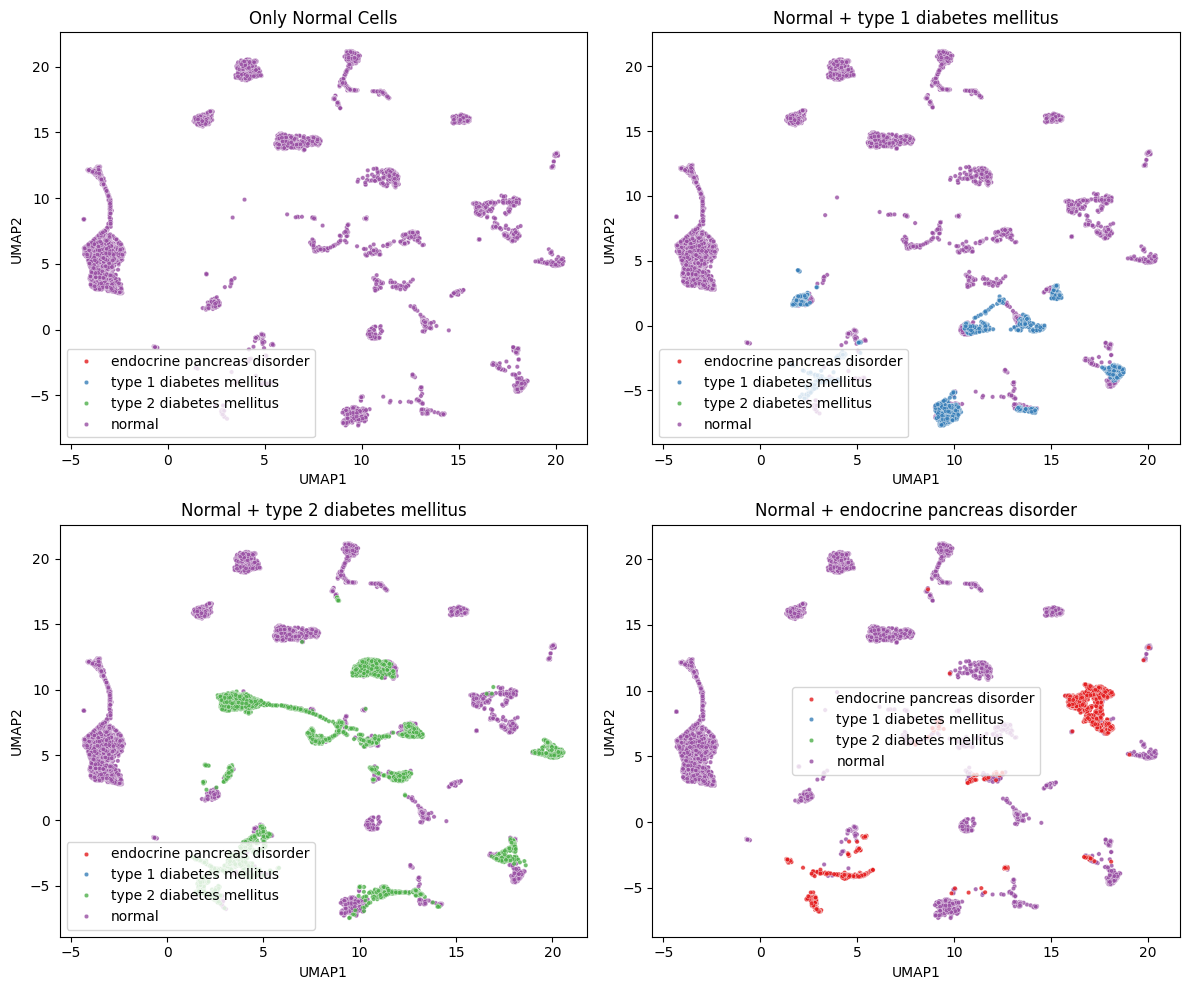

In [39]:
# === 1. Build encoder model from bottleneck layer ===
bottleneck_layer = loaded_model.get_layer(name='bottleneck')
encoder = Model(inputs=loaded_model.input, outputs=bottleneck_layer.output)

# === 2. Encode test data ===
X_encoded = encoder.predict(X_test, batch_size=64)

# === 3. UMAP embedding ===
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
X_umap = reducer.fit_transform(X_encoded)

# === 4. Create DataFrame for plotting ===
df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df["disease"] = test_data.obs["disease"].values  # assumes test_data is an AnnData object

# === 5. Prepare plotting ===
diseases = df["disease"].unique()
normal_df = df[df["disease"] == "normal"]
non_normal_diseases = [d for d in diseases if d != "normal"]

# === 6. Create subplots ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot 1: Normal only
sns.scatterplot(data=normal_df, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axes[0], palette="Set1")
axes[0].set_title("Only Normal Cells")
axes[0].legend(loc="best")

# Plot 2–4: Normal + one disease
for i, disease in enumerate(non_normal_diseases[:3]):
    subset_df = pd.concat([normal_df, df[df["disease"] == disease]])
    sns.scatterplot(data=subset_df, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axes[i+1], palette="Set1")
    axes[i+1].set_title(f"Normal + {disease}")
    axes[i+1].legend(loc="best")

plt.tight_layout()
plt.show()


472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


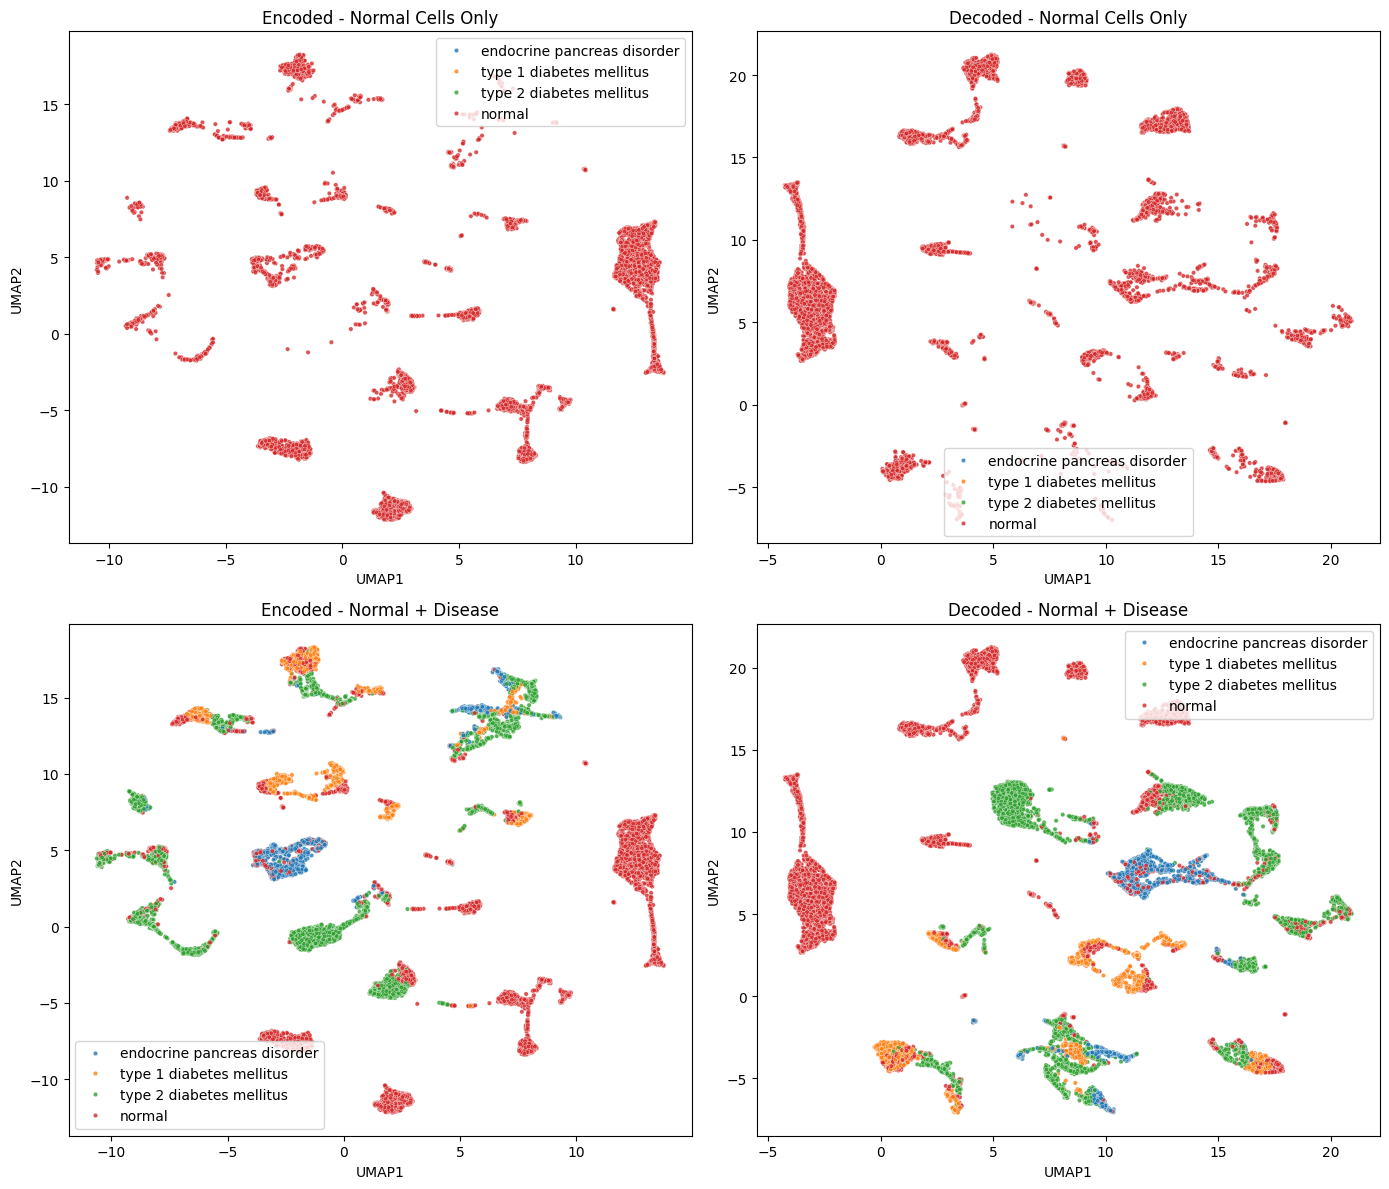

In [40]:
# === 1. Create masks and labels ===
normal_mask = test_data.obs["disease"] == "normal"
disease_labels = test_data.obs["disease"].values

# === 2. Predict encoded & decoded representations ===
X_encoded = encoder.predict(X_test, batch_size=64)
X_decoded = loaded_model.predict(X_test, batch_size=64)

# === 3. Run UMAP once per full dataset ===
umap_encoded = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_decoded = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)

X_umap_encoded_all = umap_encoded.fit_transform(X_encoded)
X_umap_decoded_all = umap_decoded.fit_transform(X_decoded)

# === 4. Create DataFrames ===
df_encoded_all = pd.DataFrame(X_umap_encoded_all, columns=["UMAP1", "UMAP2"])
df_encoded_all["disease"] = disease_labels

df_decoded_all = pd.DataFrame(X_umap_decoded_all, columns=["UMAP1", "UMAP2"])
df_decoded_all["disease"] = disease_labels

# Subset to normal only (just filter)
df_encoded_normal = df_encoded_all[df_encoded_all["disease"] == "normal"]
df_decoded_normal = df_decoded_all[df_decoded_all["disease"] == "normal"]

# === 5. Plot ===
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

# Top row: only normal
sns.scatterplot(data=df_encoded_normal, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axs[0])
axs[0].set_title("Encoded - Normal Cells Only")
axs[0].legend(loc="best")

sns.scatterplot(data=df_decoded_normal, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axs[1])
axs[1].set_title("Decoded - Normal Cells Only")
axs[1].legend(loc="best")

# Bottom row: normal + disease
sns.scatterplot(data=df_encoded_all, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axs[2])
axs[2].set_title("Encoded - Normal + Disease")
axs[2].legend(loc="best")

sns.scatterplot(data=df_decoded_all, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axs[3])
axs[3].set_title("Decoded - Normal + Disease")
axs[3].legend(loc="best")

plt.tight_layout()
plt.show()
